Generating problem data and testing for a finite solution...
Problem is unbounded or infeasible (f_star = -inf). Retrying...
Generating problem data and testing for a finite solution...
Problem is unbounded or infeasible (f_star = -inf). Retrying...
Generating problem data and testing for a finite solution...
Problem is unbounded or infeasible (f_star = -inf). Retrying...
Generating problem data and testing for a finite solution...
------------------------------
Problem setup successful: n=10, m=20
True Optimal Value (f_star): 1.040526
------------------------------

Final Results after 50000 iterations
True Optimal Value (f_star): 1.04052588
(a) Constant Step-Size:
	Final f(x): 1.20997680 	 (Gap: 0.16945092)
(b) Constant Step-Length:
	Final f(x): 1.17929996 	 (Gap: 0.13877408)
(c) Non-Summable (0.1/sqrt(k)):
	Final f(x): 1.10211266 	 (Gap: 0.06158679)
(d) Square-Summable (1/k):
	Final f(x): 1.10969210 	 (Gap: 0.06916622)



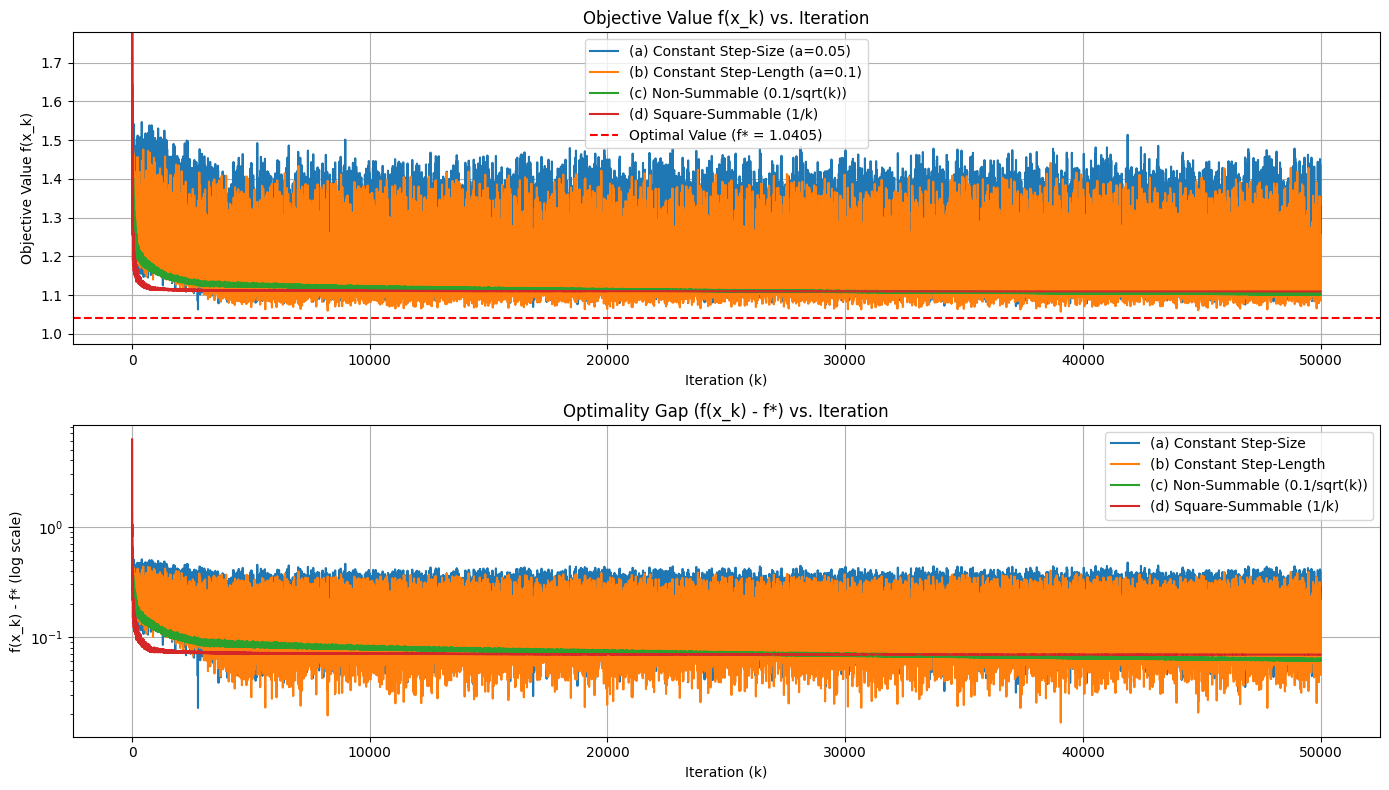

In [9]:
!pip install cvpy

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(42)
N_DIM = 10
M_FUNCS = 20
NUM_ITER = 50000

f_star = np.inf

while not np.isfinite(f_star):
    print("Generating problem data and testing for a finite solution...")

    A = np.random.randn(M_FUNCS, N_DIM)
    b = np.random.randn(M_FUNCS)
    c = np.random.randn(N_DIM)
    d = np.random.randn(1)[0]

    try:
        x_opt = cp.Variable(N_DIM)
        objective_cp = cp.Minimize(cp.max(A @ x_opt + b))
        constraints = [c @ x_opt <= d]
        problem = cp.Problem(objective_cp, constraints)

        f_star = problem.solve()
        x_star = x_opt.value

        if not np.isfinite(f_star):
            print("Problem is unbounded or infeasible (f_star = {}). Retrying...".format(f_star))

    except Exception as e:
        print(f"CVXPY solver failed: {e}. Retrying...")
        f_star = np.inf # Ensure loop continues


print("-" * 30)
print(f"Problem setup successful: n={N_DIM}, m={M_FUNCS}")
print(f"True Optimal Value (f_star): {f_star:.6f}")
print("-" * 30)


def objective(x):
    return np.max(A @ x + b)

def subgradient(x):
    j = np.argmax(A @ x + b)
    return A[j]

c_norm_sq = np.linalg.norm(c)**2

def project(y):
    if c_norm_sq < 1e-12:
        return y

    violation = c @ y - d
    if violation <= 0:
        return y
    else:
        return y - (violation / c_norm_sq) * c


x_0 = project(np.zeros(N_DIM))

x_a = x_0.copy()
x_b = x_0.copy()
x_c = x_0.copy()
x_d = x_0.copy()

f_hist_a = []
f_hist_b = []
f_hist_c = []
f_hist_d = []

alpha_const = 0.05
alpha_len = 0.1

for k in range(NUM_ITER):
    f_hist_a.append(objective(x_a))
    f_hist_b.append(objective(x_b))
    f_hist_c.append(objective(x_c))
    f_hist_d.append(objective(x_d))

    g_a = subgradient(x_a)
    alpha_k_a = alpha_const
    y_a = x_a - alpha_k_a * g_a
    x_a = project(y_a)

    g_b = subgradient(x_b)
    norm_g_b = np.linalg.norm(g_b)
    if norm_g_b > 1e-8:
        alpha_k_b = alpha_len / norm_g_b
    else:
        alpha_k_b = 0
    y_b = x_b - alpha_k_b * g_b
    x_b = project(y_b)

    g_c = subgradient(x_c)
    alpha_k_c = 0.1 / np.sqrt(k + 1)
    y_c = x_c - alpha_k_c * g_c
    x_c = project(y_c)

    g_d = subgradient(x_d)
    alpha_k_d = 1.0 / (k + 1)
    y_d = x_d - alpha_k_d * g_d
    x_d = project(y_d)

print("\n" + "=" * 40)
print(f"Final Results after {NUM_ITER} iterations")
print(f"True Optimal Value (f_star): {f_star:.8f}")
print("=" * 40)

f_final_a = f_hist_a[-1]
gap_a = f_final_a - f_star
print(f"(a) Constant Step-Size:")
print(f"\tFinal f(x): {f_final_a:.8f} \t (Gap: {gap_a:.8f})")

f_final_b = f_hist_b[-1]
gap_b = f_final_b - f_star
print(f"(b) Constant Step-Length:")
print(f"\tFinal f(x): {f_final_b:.8f} \t (Gap: {gap_b:.8f})")

f_final_c = f_hist_c[-1]
gap_c = f_final_c - f_star
print(f"(c) Non-Summable (0.1/sqrt(k)):")
print(f"\tFinal f(x): {f_final_c:.8f} \t (Gap: {gap_c:.8f})")

f_final_d = f_hist_d[-1]
gap_d = f_final_d - f_star
print(f"(d) Square-Summable (1/k):")
print(f"\tFinal f(x): {f_final_d:.8f} \t (Gap: {gap_d:.8f})")
print("=" * 40 + "\n")


plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(f_hist_a, label=f"(a) Constant Step-Size (a={alpha_const})")
plt.plot(f_hist_b, label=f"(b) Constant Step-Length (a={alpha_len})")
plt.plot(f_hist_c, label=f"(c) Non-Summable (0.1/sqrt(k))")
plt.plot(f_hist_d, label=f"(d) Square-Summable (1/k)")
plt.axhline(f_star, color='r', linestyle='--', label=f"Optimal Value (f* = {f_star:.4f})")
plt.title("Objective Value f(x_k) vs. Iteration")
plt.xlabel("Iteration (k)")
plt.ylabel("Objective Value f(x_k)")
plt.legend()
plt.grid(True)


initial_gap = f_hist_a[0] - f_star
ylim_top = f_star + initial_gap * 1.1
ylim_bottom = f_star - initial_gap * 0.1
plt.ylim(ylim_bottom, ylim_top)


plt.subplot(2, 1, 2)
plt.plot(np.maximum(1e-10, np.array(f_hist_a) - f_star), label=f"(a) Constant Step-Size")
plt.plot(np.maximum(1e-10, np.array(f_hist_b) - f_star), label=f"(b) Constant Step-Length")
plt.plot(np.maximum(1e-10, np.array(f_hist_c) - f_star), label=f"(c) Non-Summable (0.1/sqrt(k))")
plt.plot(np.maximum(1e-10, np.array(f_hist_d) - f_star), label=f"(d) Square-Summable (1/k)")
plt.title("Optimality Gap (f(x_k) - f*) vs. Iteration")
plt.xlabel("Iteration (k)")
plt.ylabel("f(x_k) - f* (log scale)")
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Running Simulation for f1(x) ---
f1(x) optimal point x* = 3.451582705289455


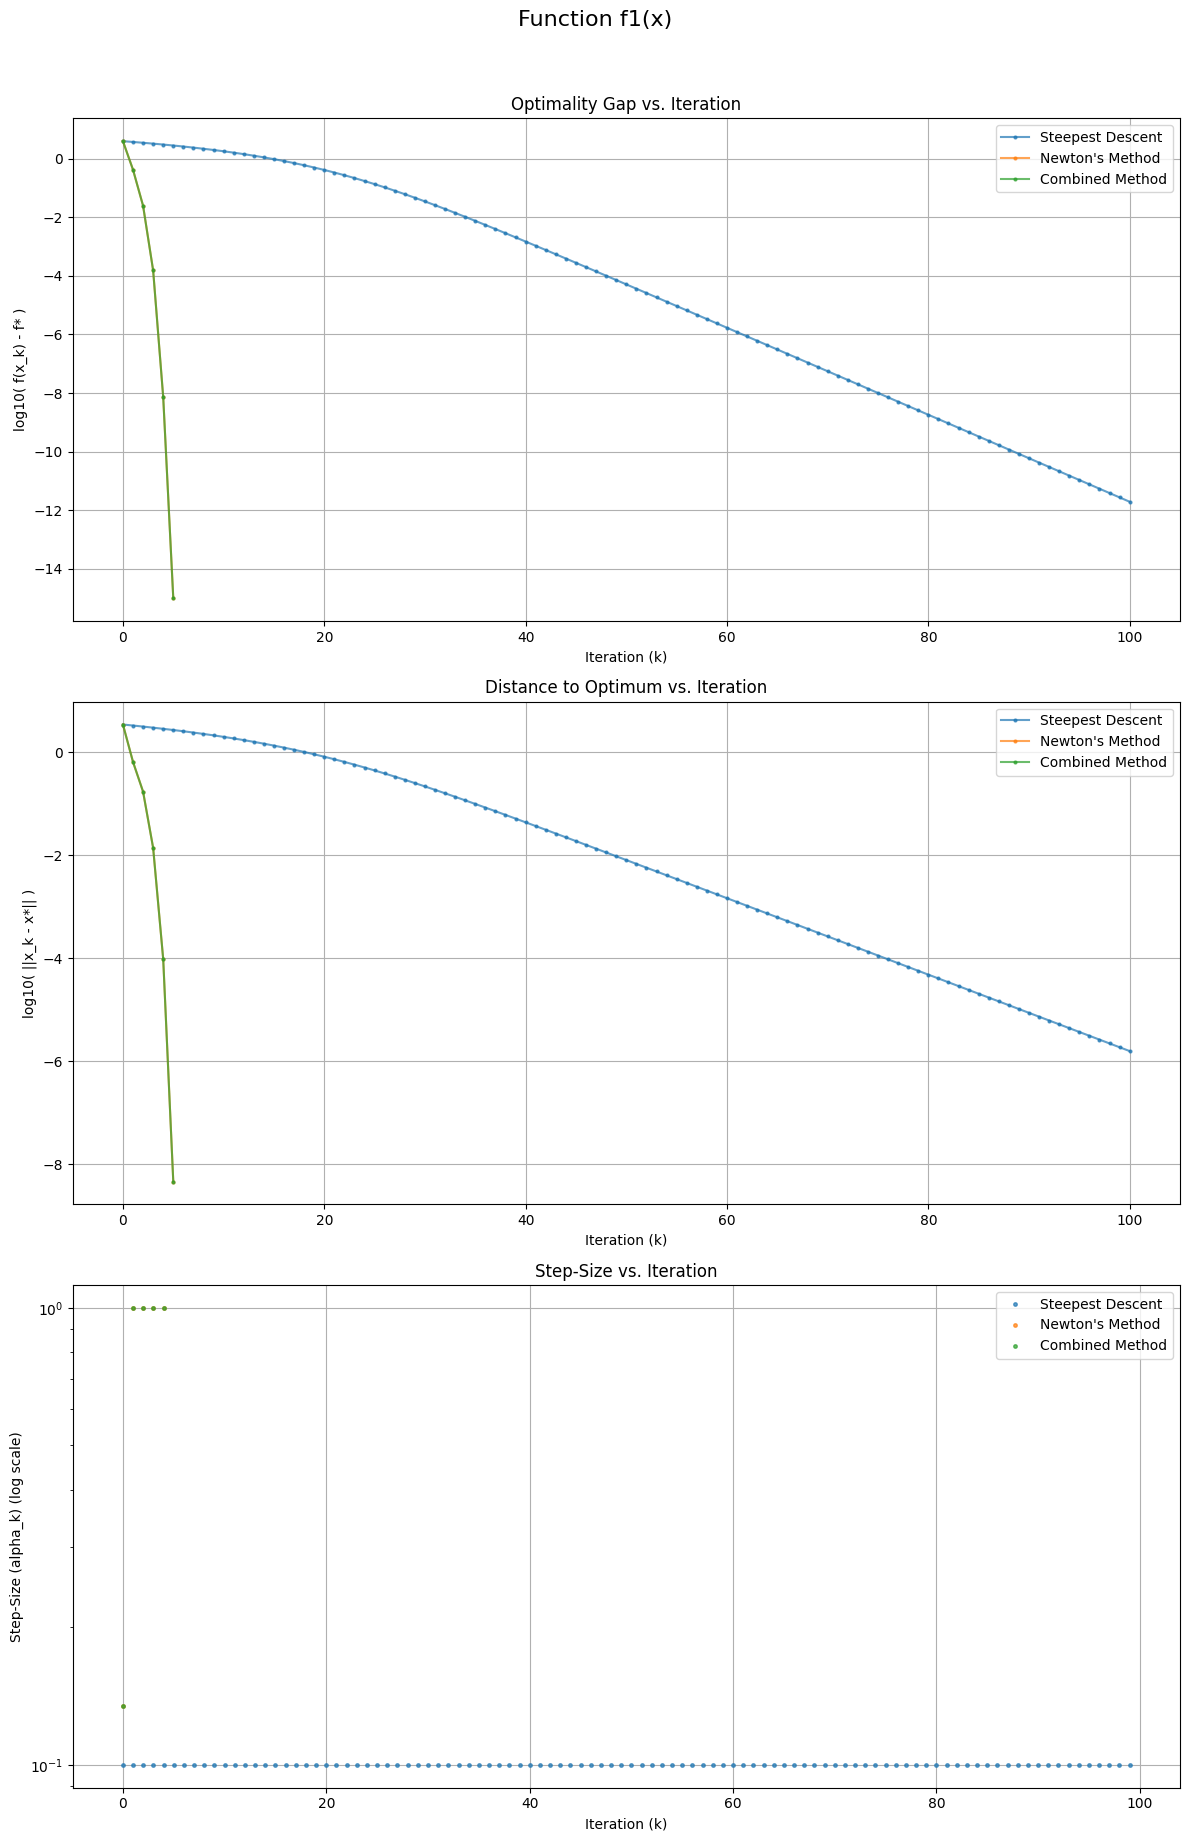


--- Running Simulation for f2(x) ---
f2(x) global optimal point x* = -17.8230553755357 (Hardcoded to prevent errors)
Using new, stable starting point: x0 = -20.0


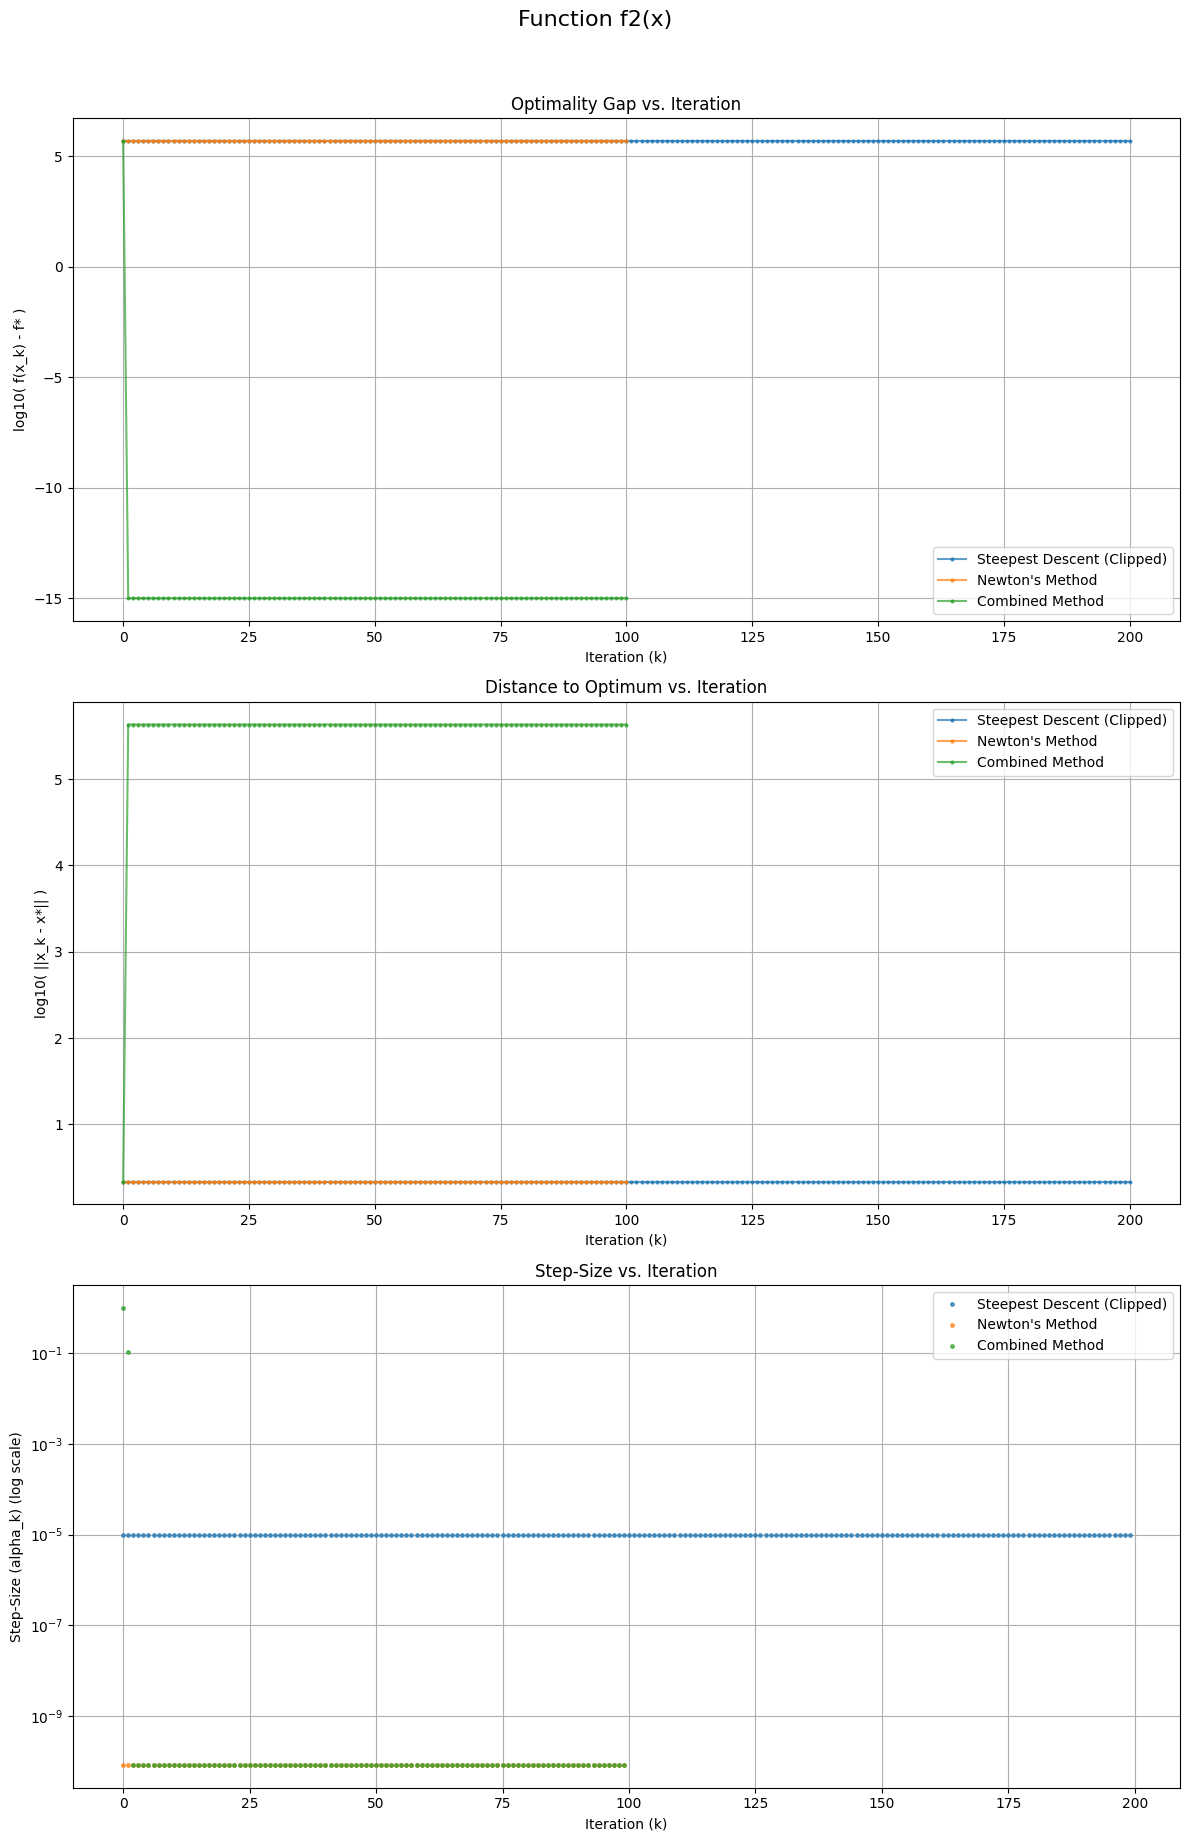

f2(x) global optimal point x* = -2.4993928202580973 (found numerically in [-20, 20])


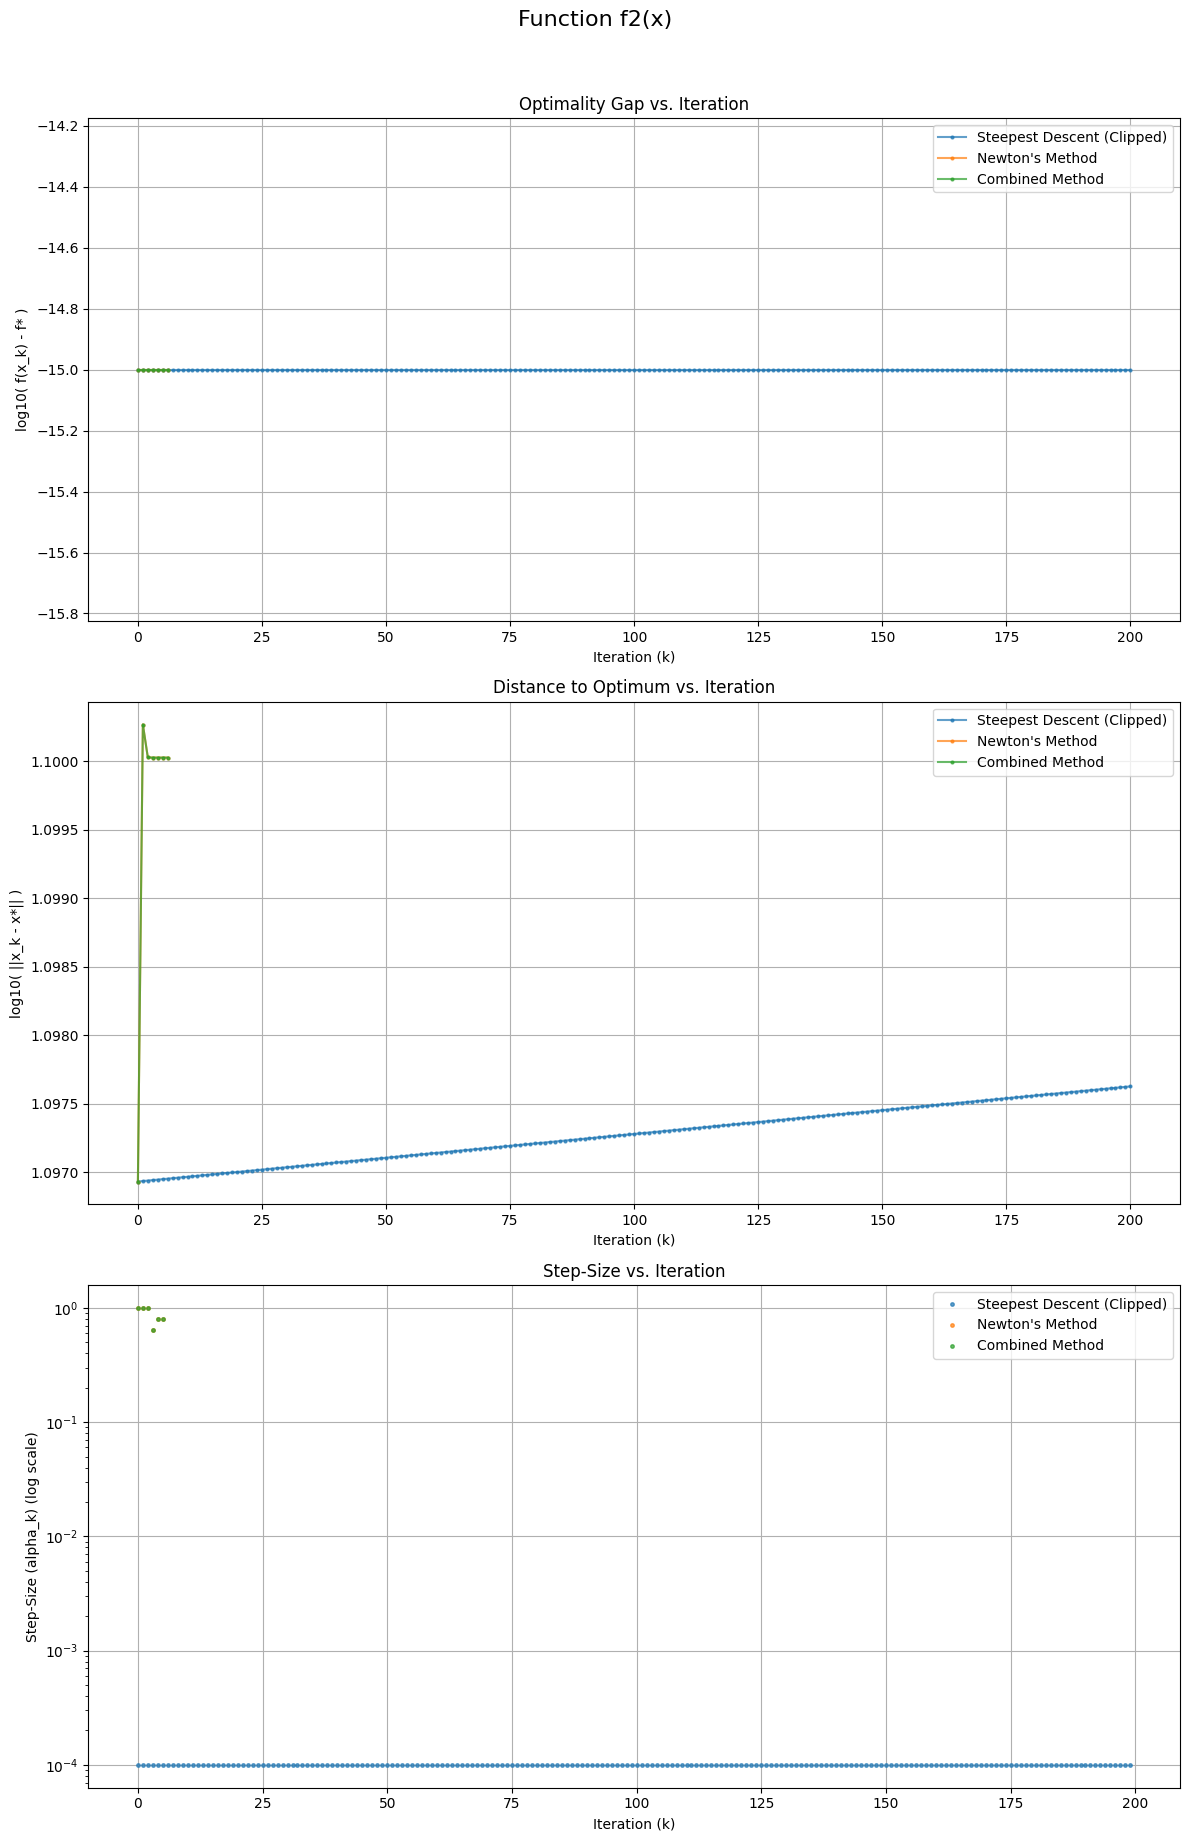


--- Running Simulation for f3(x) (Rosenbrock) ---
f3(x) optimal point x* = [1. 1.]


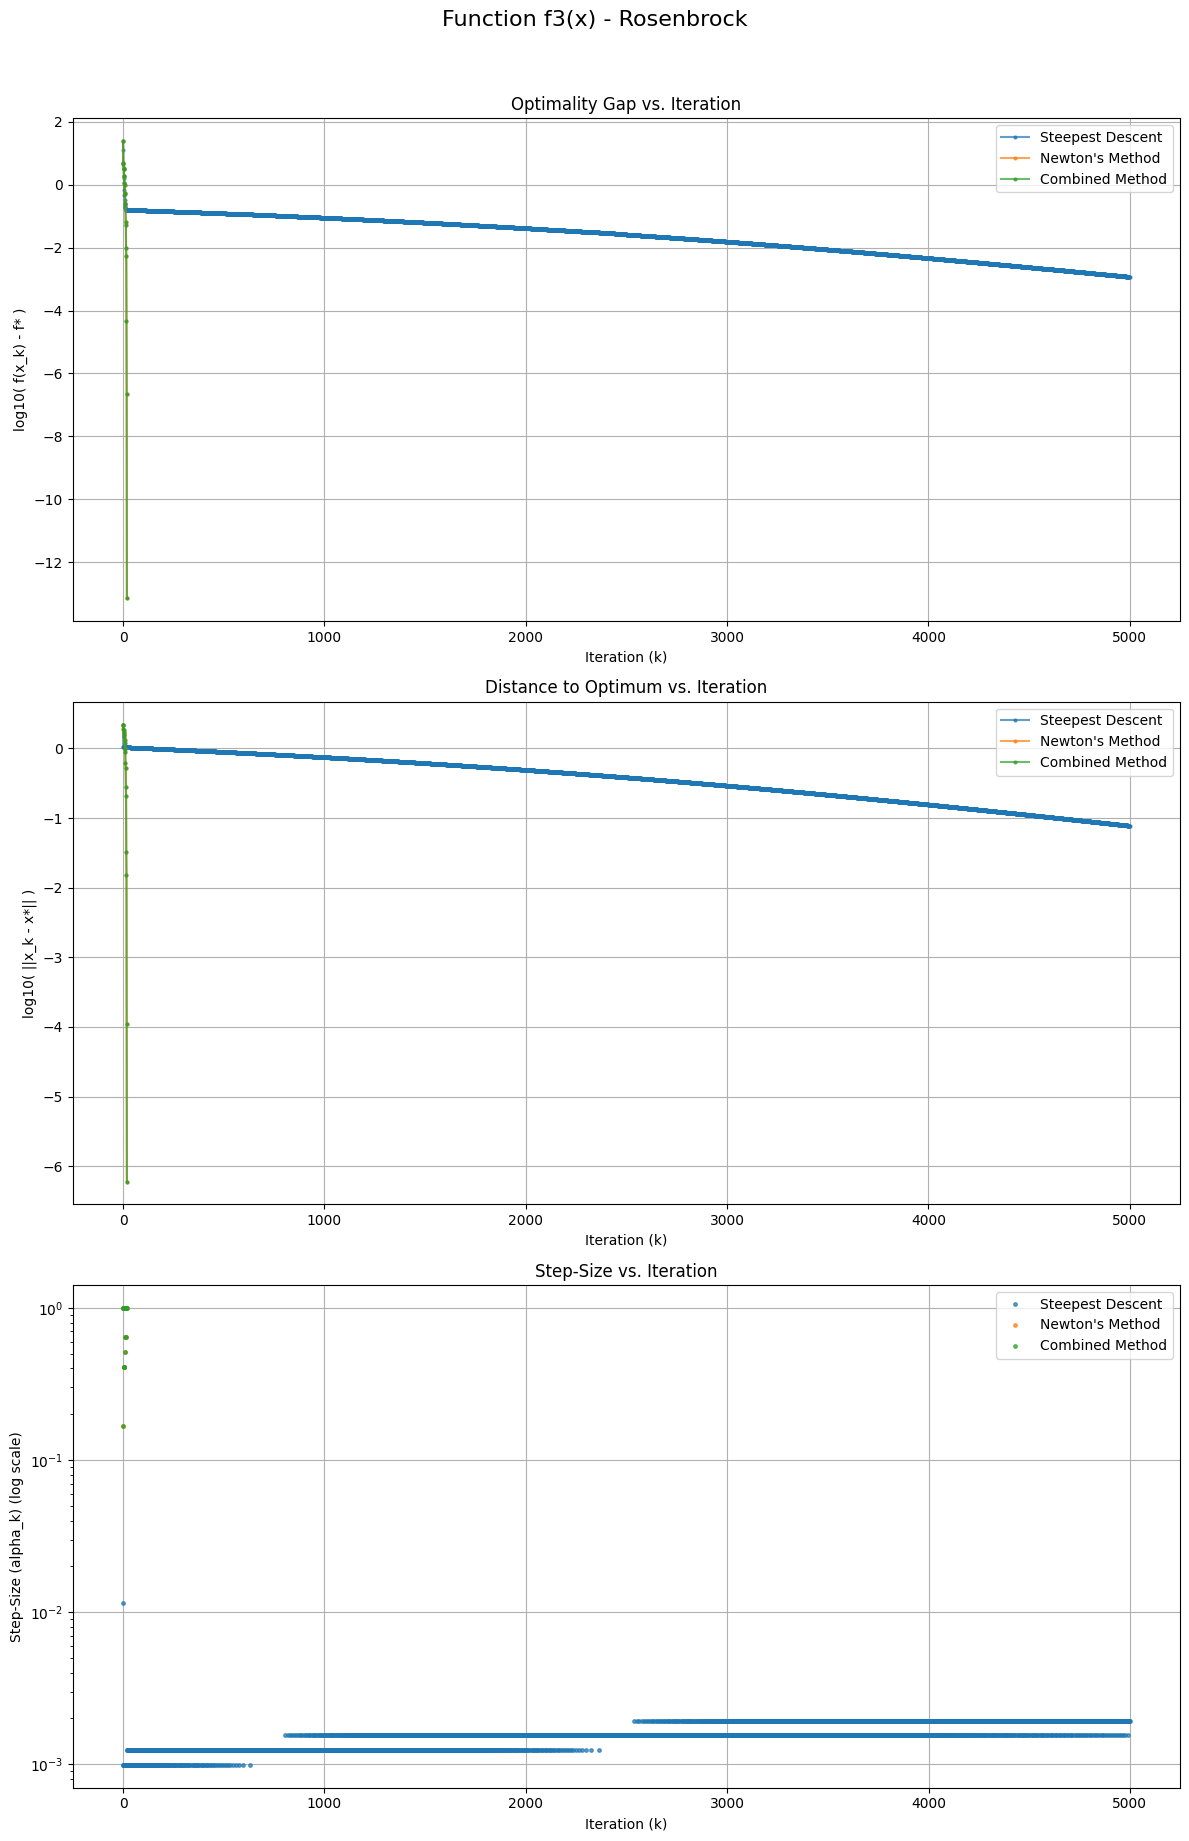

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve, eigvals
from scipy.optimize import minimize_scalar

# 1D OPTIMIZATION ALGORITHMS (for f1, f2)

def backtracking_1d(f, grad, x, p, c=1e-4, beta=0.8, alpha_0=1.0):
    """Backtracking line search for 1D functions"""
    alpha = alpha_0
    fx = f(x)
    g_x = grad(x)

    while f(x + alpha * p) > fx + c * alpha * g_x * p:
        alpha = beta * alpha
        if alpha < 1e-10:
            break
    return alpha

def steepest_descent_1d(f, grad, x0, x_star, max_iter=1000, tol=1e-6, grad_clip=100.0):
    x = x0
    history = {'f_val': [f(x)], 'dist': [np.abs(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)

        if np.abs(g) < tol:
            break

        if np.abs(g) > grad_clip:
            g = g * (grad_clip / np.abs(g)) # This is np.sign(g) * grad_clip

        p = -g

        alpha = backtracking_1d(f, grad, x, p, alpha_0=0.1)
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(np.abs(x - x_star))
        history['step_size'].append(alpha)

    return history

def newton_method_1d(f, grad, hess, x0, x_star, max_iter=100, tol=1e-6):
    x = x0
    history = {'f_val': [f(x)], 'dist': [np.abs(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)
        if np.abs(g) < tol:
            break

        H = hess(x)
        if np.abs(H) < 1e-8:
            p = -g
        else:
            p = -g / H

        alpha = backtracking_1d(f, grad, x, p)
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(np.abs(x - x_star))
        history['step_size'].append(alpha)

    return history

def combined_method_1d(f, grad, hess, x0, x_star, max_iter=100, tol=1e-6):
    x = x0
    history = {'f_val': [f(x)], 'dist': [np.abs(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)
        if np.abs(g) < tol:
            break

        H = hess(x)
        if H <= 1e-8:
            p = -g
        else:
            p = -g / H

        alpha = backtracking_1d(f, grad, x, p)
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(np.abs(x - x_star))
        history['step_size'].append(alpha)

    return history

# n-D OPTIMIZATION ALGORITHMS (for f3)

def backtracking_nd(f, grad, x, p, c=1e-4, beta=0.8, alpha_0=1.0):
    """Backtracking line search for n-D functions"""
    alpha = alpha_0
    fx = f(x)
    grad_x = grad(x)

    while f(x + alpha * p) > fx + c * alpha * np.dot(grad_x, p):
        alpha = beta * alpha
        if alpha < 1e-10:
            break
    return alpha

def steepest_descent_nd(f, grad, x0, x_star, max_iter=5000, tol=1e-6):
    x = x0.copy()
    history = {'f_val': [f(x)], 'dist': [norm(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)
        if norm(g) < tol:
            break

        p = -g
        alpha = backtracking_nd(f, grad, x, p)
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(norm(x - x_star))
        history['step_size'].append(alpha)

    return history

def newton_method_nd(f, grad, hess, x0, x_star, max_iter=100, tol=1e-6):
    x = x0.copy()
    history = {'f_val': [f(x)], 'dist': [norm(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)
        if norm(g) < tol:
            break

        H = hess(x)
        try:

            if np.all(eigvals(H) > 1e-8):
                 p = solve(H, -g)
            else:
                 p = -g
        except np.linalg.LinAlgError:
            p = -g

        if np.dot(g, p) > 0:
            p = -g

        alpha = backtracking_nd(f, grad, x, p, alpha_0=1.0) # Always try alpha=1 first
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(norm(x - x_star))
        history['step_size'].append(alpha)

    return history

def combined_method_nd(f, grad, hess, x0, x_star, max_iter=100, tol=1e-6):
    x = x0.copy()
    history = {'f_val': [f(x)], 'dist': [norm(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)
        if norm(g) < tol:
            break

        H = hess(x)
        try:
            eigenvalues = eigvals(H)
            if np.all(eigenvalues > 1e-8):
                p = solve(H, -g)
            else:
                p = -g
        except np.linalg.LinAlgError:
            p = -g

        alpha = backtracking_nd(f, grad, x, p)
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(norm(x - x_star))
        history['step_size'].append(alpha)

    return history

# UNIVERSAL PLOTTING FUNCTION

def plot_results(histories, title_prefix, f_star):
    """
    Plots the 3 required graphs for a set of optimization histories.
    'histories' is a dict: {'Method Name': history_dict, ...}
    """
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    fig.suptitle(title_prefix, fontsize=16, y=1.02)

    ax = axs[0]
    for name, hist in histories.items():
        f_vals_gap = np.maximum(1e-15, np.array(hist['f_val']) - f_star)
        ax.plot(np.log10(f_vals_gap), label=name, marker='.', markersize=4, alpha=0.7)
    ax.set_title("Optimality Gap vs. Iteration")
    ax.set_ylabel("log10( f(x_k) - f* )")
    ax.set_xlabel("Iteration (k)")
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    for name, hist in histories.items():
        dist_vals = np.maximum(1e-15, hist['dist'])
        ax.plot(np.log10(dist_vals), label=name, marker='.', markersize=4, alpha=0.7)
    ax.set_title("Distance to Optimum vs. Iteration")
    ax.set_ylabel("log10( ||x_k - x*|| )")
    ax.set_xlabel("Iteration (k)")
    ax.legend()
    ax.grid(True)

    ax = axs[2]
    for name, hist in histories.items():
        ax.plot(hist['step_size'], label=name, marker='.', markersize=5, linestyle='None', alpha=0.7)
    ax.set_title("Step-Size vs. Iteration")
    ax.set_ylabel("Step-Size (alpha_k) (log scale)")
    ax.set_xlabel("Iteration (k)")
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# SIMULATION 1: f1(x)

print("\n--- Running Simulation for f1(x) ---")

def f1(x):
    return np.exp(x - 3) - (np.pi / 2) * x - 2

def grad_f1(x):
    return np.exp(x - 3) - (np.pi / 2)

def hess_f1(x):
    return np.exp(x - 3)

x_star_f1 = 3 + np.log(np.pi / 2)
f_star_f1 = f1(x_star_f1)
print(f"f1(x) optimal point x* = {x_star_f1}")

x0_f1 = 0.0
hist_sd_f1 = steepest_descent_1d(f1, grad_f1, x0_f1, x_star_f1, max_iter=100)
hist_nm_f1 = newton_method_1d(f1, grad_f1, hess_f1, x0_f1, x_star_f1)
hist_cm_f1 = combined_method_1d(f1, grad_f1, hess_f1, x0_f1, x_star_f1)

histories_f1 = {
    "Steepest Descent": hist_sd_f1,
    "Newton's Method": hist_nm_f1,
    "Combined Method": hist_cm_f1
}
plot_results(histories_f1, "Function f1(x)", f_star_f1)


# SIMULATION 2: f2(x)

print("\n--- Running Simulation for f2(x) ---")

CLIP_VAL = 100.0

def f2(x):
    pow_term = np.power(2.0, np.clip(-x, -np.inf, CLIP_VAL))
    return -(1 + pow_term) * np.cos(x) * np.sin(x)

def grad_f2(x):
    log2 = np.log(2)
    pow_term = np.power(2.0, np.clip(-x, -np.inf, CLIP_VAL))
    p1 = (log2 / 2) * pow_term * np.sin(2 * x)
    p2 = -(1 + pow_term) * np.cos(2 * x)
    if not np.isfinite(p1) or not np.isfinite(p2): return np.sign(p1 + p2) * 1e300
    return p1 + p2

def hess_f2(x):
    log2 = np.log(2)
    pow_term = np.power(2.0, np.clip(-x, -np.inf, CLIP_VAL))
    p1 = (2 + (2 - (log2**2)/2) * pow_term) * np.sin(2 * x)
    p2 = (2 * log2 * pow_term) * np.cos(2 * x)
    if not np.isfinite(p1) or not np.isfinite(p2): return 1.0
    return p1 + p2

def steepest_descent_1d(f, grad, x0, x_star, max_iter=1000, tol=1e-6, grad_clip=0.5):
    x = x0
    history = {'f_val': [f(x)], 'dist': [np.abs(x - x_star)], 'step_size': []}
    for _ in range(max_iter):
        g = grad(x)
        if np.abs(g) < tol: break
        if np.abs(g) > grad_clip: g = g * (grad_clip / np.abs(g))
        p = -g
        alpha = backtracking_1d(f, grad, x, p, alpha_0=1e-5)
        x = x + alpha * p
        history['f_val'].append(f(x)); history['dist'].append(np.abs(x - x_star)); history['step_size'].append(alpha)
    return history

x_star_f2 = -17.8230553755357
f_star_f2 = f2(x_star_f2)
print(f"f2(x) global optimal point x* = {x_star_f2} (Hardcoded to prevent errors)")

x0_f2 = -20.0
print(f"Using new, stable starting point: x0 = {x0_f2}")

hist_sd_f2 = steepest_descent_1d(f2, grad_f2, x0_f2, x_star_f2, max_iter=200)
hist_nm_f2 = newton_method_1d(f2, grad_f2, hess_f2, x0_f2, x_star_f2)
hist_cm_f2 = combined_method_1d(f2, grad_f2, hess_f2, x0_f2, x_star_f2)

histories_f2 = {
    "Steepest Descent (Clipped)": hist_sd_f2,
    "Newton's Method": hist_nm_f2,
    "Combined Method": hist_cm_f2
}
plot_results(histories_f2, "Function f2(x)", f_star_f2)

def steepest_descent_1d(f, grad, x0, x_star, max_iter=1000, tol=1e-6, grad_clip=1.0): # <-- Smaller clip
    x = x0
    history = {'f_val': [f(x)], 'dist': [np.abs(x - x_star)], 'step_size': []}

    for _ in range(max_iter):
        g = grad(x)

        if np.abs(g) < tol:
            break

        if np.abs(g) > grad_clip:
            g = g * (grad_clip / np.abs(g))

        p = -g

        alpha = backtracking_1d(f, grad, x, p, alpha_0=1e-4) # <-- Smaller alpha
        x = x + alpha * p

        history['f_val'].append(f(x))
        history['dist'].append(np.abs(x - x_star))
        history['step_size'].append(alpha)

    return history

sol_f2 = minimize_scalar(f2, bounds=(-20, 20), method='bounded')
x_star_f2 = sol_f2.x
f_star_f2 = sol_f2.fun
print(f"f2(x) global optimal point x* = {x_star_f2} (found numerically in [-20, 20])")

x0_f2 = -15.0
hist_sd_f2 = steepest_descent_1d(f2, grad_f2, x0_f2, x_star_f2, max_iter=200)
hist_nm_f2 = newton_method_1d(f2, grad_f2, hess_f2, x0_f2, x_star_f2)
hist_cm_f2 = combined_method_1d(f2, grad_f2, hess_f2, x0_f2, x_star_f2)

histories_f2 = {
    "Steepest Descent (Clipped)": hist_sd_f2,
    "Newton's Method": hist_nm_f2,
    "Combined Method": hist_cm_f2
}
plot_results(histories_f2, "Function f2(x)", f_star_f2)

# SIMULATION 3:  f3(x)

print("\n--- Running Simulation for f3(x) (Rosenbrock) ---")

def f3(x):
    x1, x2 = x[0], x[1]
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

def grad_f3(x):
    x1, x2 = x[0], x[1]
    df_dx1 = -400 * x1 * (x2 - x1**2) - 2 * (1 - x1)
    df_dx2 = 200 * (x2 - x1**2)
    return np.array([df_dx1, df_dx2])

def hess_f3(x):
    x1, x2 = x[0], x[1]
    d2f_dx1_dx1 = 1200 * x1**2 - 400 * x2 + 2
    d2f_dx1_dx2 = -400 * x1
    d2f_dx2_dx2 = 200
    return np.array([
        [d2f_dx1_dx1, d2f_dx1_dx2],
        [d2f_dx1_dx2, d2f_dx2_dx2]
    ])

x_star_f3 = np.array([1.0, 1.0])
f_star_f3 = f3(x_star_f3)
print(f"f3(x) optimal point x* = {x_star_f3}")

x0_f3 = np.array([-1.2, 1.0])

hist_sd_f3 = steepest_descent_nd(f3, grad_f3, x0_f3, x_star_f3)
hist_nm_f3 = newton_method_nd(f3, grad_f3, hess_f3, x0_f3, x_star_f3)
hist_cm_f3 = combined_method_nd(f3, grad_f3, hess_f3, x0_f3, x_star_f3)

histories_f3 = {
    "Steepest Descent": hist_sd_f3,
    "Newton's Method": hist_nm_f3,
    "Combined Method": hist_cm_f3
}
plot_results(histories_f3, "Function f3(x) - Rosenbrock", f_star_f3)